In [1]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
import pandas as pd

import cv2
import numpy as np
import supervision as sv
from os.path import expanduser
import json
from unet_model import *
import segmentation_models_pytorch as smp
from scipy.spatial.distance import cdist
from strategies import *
from custom_datasets import *
import torch.optim as optim

In [2]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
notebooks_path = main_path + "scripts/notebooks/"
expirements_path = main_path+"expirements/"
processed_data_path = main_path + "data/processed/"
trained_models = main_path + "scripts/notebooks/trained_models/"
combinations_dataframe_path = dataframes_path + "comp_df.csv"
similarity_train_data_path = processed_data_path + "train_similarity/"

In [3]:
if not os.path.exists(similarity_train_data_path):
    os.makedirs(similarity_train_data_path)

In [4]:
# df_name = "lung_df"
# train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
# test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

df_name = "brain_df"
train_df = pd.read_csv(dataframes_path+"brain_df_train.csv")
test_df = pd.read_csv(dataframes_path+"brain_df_test.csv")




In [5]:
with open("brain_params.json", "r") as f:
    params = json.load(f)
# with open("lung_params.json", "r") as f:
#     params = json.load(f)

# with open("lunar_params.json", "r") as f:
#     params = json.load(f)

In [6]:
if params["init_set_size"] == len(train_df):
    params["training_type"] = "no_active"
elif not params["use_sam"]:
    params["training_type"] = "no_sam"
elif params["voting"]:
    params["training_type"] = "voters"
else:
    params["training_type"]="withSAM_NoVoting"

if params["training_type"] == "no_active":
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/pre_trained_Unet_{params["img_size"][0]}.pt'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/not_pre_trained_Unet_{params["img_size"][0]}.pt'
else:
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/pre_trained/{params["init_set_size"]}'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/not_pre_trained/{params["init_set_size"]}'

notes = f'{params["training_type"]}_{params["init_set_size"]}'

if params["dropout"] and params["training_type"] != "voters":
    params["model_path"] = f'{params["model_path"]}_dropout'
    notes = f"{notes}_dropout"

params['test_set_size'] = len(test_df)
params['df'] = df_name
params['query_num'] = int(0.05 * params['init_set_size'])
if params['query_num'] == 0:
    params['query_num'] = 1
params["strategy"] = "MarginSampling"



if params["training_type"] == "voters":
    if params["similarity_check"]:
        params["model_path"] = f'{params["model_path"]}_dbscan'
        notes = f"{notes}_dbscan"
    if params["dropout"]:
        params["model_path"] = f'{params["model_path"]}_dropout'
    params["model_path"] = f'{params["model_path"]}/voters_{params["img_size"][0]}'
        

In [7]:
params["model_path"]

'/home/jovyan/Active-Learning-Segmentation/scripts/notebooks/trained_models/Brain_Tumor_Segmentation/voters/pre_trained/100_dbscan/voters_128'

In [8]:
voters = [f'{params["model_path"]}_{1}/model_{i}.pt' for i in range(1,10)]
voters.append(f'{params["model_path"]}_{1}/main_Unet.pt')

In [9]:
test_df_slice = train_df[:300]
def get_data(handler, train_df, test_df):
    return Data(train_df["images"].to_list(), train_df["masks"].to_list(), test_df["images"].to_list(), test_df["masks"].to_list(), handler, img_size=params["img_size"], df=train_df, path= main_path+"/data/processed/", use_sam=params['use_sam'])

data = get_data(Handler, test_df_slice, test_df_slice)
data.initialize_labels(params["init_set_size"])

In [10]:
if params["pre_trained"]:
    model = smp.create_model('Unet', encoder_name='resnet34', in_channels=3, classes = 1)
else:
    model = UNet(n_channels=3, n_classes=1, bilinear=True)
net = Net(model, params, device = torch.device("cuda"))

In [11]:
sam = SAMOracle(checkpoint_path=sam_path, img_size=params["img_size"])

In [12]:
def predict(net, model_state:str):
    net.net.load_state_dict(torch.load(model_state))
    net.clf = net.net.to(torch.device("cuda"))
    mask = net.predict(data.get_test_data())[0]
    mask = (mask.squeeze().cpu().sigmoid()> 0.5).float()
    
    return mask

In [13]:
def get_boxes(mask):
    if torch.is_tensor(mask):
        mask = mask.numpy()
        mask = np.array(mask, np.uint8)
    # _, thresh = cv2.threshold(mask, 0.5, 1, 0)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    return np.array(cnts)   

In [14]:
tmp_masks = [predict(net, path) for path in voters]
voters_masks =[]
for j in range(len(tmp_masks[0])):
    voters_masks.append([tmp_masks[i][j] for i in range(len(tmp_masks))])

In [15]:
voters_boxes = [[get_boxes(mask) for mask in masks] for masks in voters_masks]

In [16]:
mask_paths = []
gt_paths =[]
mask_paths_remove=[]
for i in range(len(test_df_slice)):
    gt_mask= np.load(test_df_slice["masks"][i], allow_pickle=True)
    if gt_mask.sum()>0:
        for j in range(10):
            mask_paths.append(similarity_train_data_path + f"sam_{j}_" + os.path.basename(test_df_slice["masks"][i]))
            gt_paths.append(test_df_slice["masks"][i])
    else:
        for j in range(10):
            mask_paths_remove.append(similarity_train_data_path + f"sam_{j}_" + os.path.basename(test_df_slice["masks"][i]))

In [17]:
comp_df = pd.DataFrame({"mask":mask_paths,
                      "gt_mask":gt_paths})

# comp_df.to_csv(dataframes_path+"comp_df.csv")

# comp_df = pd.read_csv(dataframes_path+"comp_df.csv")

In [18]:
len(comp_df)

1080

In [19]:
train_size = int(0.7*len(comp_df)/10)*10

In [20]:
train_size

750

In [21]:
train_comp_df = comp_df[:train_size]

test_comp_df = comp_df[train_size:].reset_index(drop=True)

# train_comp_df.to_csv(dataframes_path+"train_comp_df.csv")
# test_comp_df.to_csv(dataframes_path+"test_comp_df.csv")

In [22]:
# train_comp_df = pd.read_csv(dataframes_path+"train_comp_df.csv")
# test_comp_df = pd.read_csv(dataframes_path+"test_comp_df.csv")

In [23]:
voters_sam=[]
for i,boxes in enumerate(voters_boxes):
    tmp_sams=[]
    for j,box in enumerate(boxes):
        path = similarity_train_data_path + f"sam_{j}_" + os.path.basename(test_df_slice["masks"][i])
        if not os.path.isfile(path):
            tmp_sam = sam.get_mask(img_path=test_df_slice["images"][i], boxes=box).squeeze()
            tmp_sams.append(tmp_sam)
            np.save(path, tmp_sam)

In [24]:
# for path in mask_paths_remove:
#     os.remove(path)

In [25]:
def get_similarity(masks, gt_masks):
    iou = torch.zeros((masks.shape[0],1))
    for i in range(len(masks)):
        tp, fp, fn, tn = smp.metrics.get_stats(masks[i].long(), gt_masks[i].long(), mode="binary", threshold=0.5)
        iou[i] = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    return iou
        

In [26]:
comps = []
poses=[]
negs=[]
pos=[]
neg=[]
for i in range(0, train_size,10):
    for j in range(i,i+10):
        mask = torch.Tensor(np.load(train_comp_df["mask"][j], allow_pickle=True)).view(1,128,128)
        gt_mask = torch.Tensor(np.load(train_comp_df["gt_mask"][j], allow_pickle=True)).view(1,128,128)
        if get_similarity(mask, gt_mask).squeeze()>0.5:
            pos.append(j)
        if get_similarity(mask, gt_mask).squeeze()<=0.5:
            neg.append(j)
    if len(pos) >0 and len(neg) >0:
        # print("pos:",pos,"neg:",neg)
        poses.append(pos)
        negs.append(neg)
    pos=[]
    neg=[]

comp = []
for pos, neg in zip(poses, negs):
    for p in pos:
        for n in neg:
            comp.append((p,n))

pos_paths=[]
neg_paths=[]
gt_paths=[]
for com in comp:
    pos_paths.append(comp_df["mask"][com[0]])
    neg_paths.append(comp_df["mask"][com[1]])
    gt_paths.append(comp_df["gt_mask"][com[1]])


train_triplet_df = pd.DataFrame({"pos":pos_paths,
                          "neg":neg_paths,
                          "anchor":gt_paths})

In [27]:
comps = []
poses=[]
negs=[]
pos=[]
neg=[]
for i in range(0, len(test_comp_df),10):
    for j in range(i,i+10):
        mask = torch.Tensor(np.load(test_comp_df["mask"][j], allow_pickle=True)).view(1,128,128)
        gt_mask = torch.Tensor(np.load(test_comp_df["gt_mask"][j], allow_pickle=True)).view(1,128,128)
        if get_similarity(mask, gt_mask).squeeze()>0.5:
            pos.append(j)
        if get_similarity(mask, gt_mask).squeeze()<=0.5:
            neg.append(j)
    if len(pos) >0 and len(neg) >0:
        # print("pos:",pos,"neg:",neg)
        poses.append(pos)
        negs.append(neg)
    pos=[]
    neg=[]

comp = []
for pos, neg in zip(poses, negs):
    for p in pos:
        for n in neg:
            comp.append((p,n))


pos_paths=[]
neg_paths=[]
gt_paths=[]
for com in comp:
    pos_paths.append(test_comp_df["mask"][com[0]])
    neg_paths.append(test_comp_df["mask"][com[1]])
    gt_paths.append(test_comp_df["gt_mask"][com[1]])

test_triplet_df = pd.DataFrame({"pos":pos_paths,
                          "neg":neg_paths,
                          "anchor":gt_paths})

In [28]:
# train_triplet_df.to_csv(dataframes_path+"train_triplet_df.csv")
# test_triplet_df.to_csv(dataframes_path+"test_triplet_df.csv")

# train_triplet_df = pd.read_csv(dataframes_path+"train_triplet_df.csv")
# test_triplet_df = pd.read_csv(dataframes_path+"test_triplet_df.csv")

In [29]:
triplet_df = pd.concat([train_triplet_df, test_triplet_df]).reset_index(drop=True)
# triplet_df.to_csv(dataframes_path+"triplet_df.csv")

# triplet_df = pd.read_csv(dataframes_path+"triplet_df.csv")

print(len(triplet_df))

683


In [30]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [31]:
class SimEmbeddings(nn.Module):
    def __init__(self, inp_dim):
        super(SimEmbeddings, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        #After Conv
        # new_shape = ((old_shape−Kernal_Size+2Padding)/Stride)+1.
        inp_dim-=4
        #After Maxpooling
        #new_shape = old_shape/pooling_size
        inp_dim/=2
        #Flatten
        #64 out channels of the last conv layer
        inp_dim*=inp_dim*64
        self.fc1 = nn.Linear(int(inp_dim), 128)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        return x

In [32]:
# class SimEmbeddings(torch.nn.Module):
#     def __init__(self, dim):
#         super(SimEmbeddings, self).__init__()
#         dim_2 = int(dim/2)
#         self.layer1 = torch.nn.Linear(dim, dim_2)
#         self.layer2 = torch.nn.Linear(dim_2, dim_2)
#         self.layer3 = torch.nn.Linear(dim_2, 1)
#         self.layer4 = torch.nn.Linear(dim, 1)
#         # self.relu = torch.nn.ReLU()
#         # self.sigmoid = torch.nn.Sigmoid()
        
#     def forward(self, x):
#         x1 = self.layer1(x)
#         # print(x1.shape)
#         x2 = self.layer2(x1)
#         # print(x2.shape)
#         x3 = self.layer3(x2)
#         # print(x3.shape)
#         # x4 = self.layer4(torch.permute(x3,(0, 2, 1)))
#         # print(x4.shape)
#         return torch.permute(x3,(0,1, 3, 2))
#         # return self.sigmoid(x4)
#         # return self.relu(x4)

In [64]:
class SimNet:
    def __init__(self, sim_model, params):
        self.sim_model = sim_model
        self.params = params
        # self.optimizer = optim.SGD(list(self.sim_model.parameters()),lr = 5e-5, momentum=0.9)
        self.optimizer = optim.Adam(list(self.sim_model.parameters()),lr = 2e-5)
        self.loss_fn = torch.nn.TripletMarginLoss(margin=11.0)

    def get_similarity(self, masks, gt_masks):
        iou = torch.zeros((masks.shape[0],1))
        for i in range(len(masks)):
            tp, fp, fn, tn = smp.metrics.get_stats(masks[i].long(), gt_masks[i].long(), mode="binary", threshold=0.5)
            iou[i] = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        return iou
        
        # iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="none")
        # return iou.sum(axis=1)/masks.shape[1]

    def train(self, data):
        losses = []
        epoch_loss=[]
        n_epoch = self.params['n_epoch']
        self.sim_model = self.sim_model.to("cuda")
        self.sim_model.train()
        
        loader = DataLoader(data, shuffle=True, batch_size=32)
        prog_bar = tqdm.tqdm(range(1, 60 + 1), ncols = 100, disable = False)
        for epoch in prog_bar:
            # for batch_idx, (x, y) in enumerate(loader):
            for batch_idx, (anchor, pos, neg) in enumerate(loader):
            
                # x, y = x.cuda(), y.cuda()
                anchor, pos, neg = anchor.cuda(), pos.cuda(), neg.cuda()
                self.optimizer.zero_grad()

                # predicted_similarity = self.sim_model(x).squeeze()
                anchor = self.sim_model(anchor)
                pos = self.sim_model(pos)
                neg = self.sim_model(neg)
                # gt_similarity = self.get_similarity(x,y).squeeze()
                # loss = self.loss_fn(predicted_similarity, gt_similarity)                
                loss = self.loss_fn(anchor, pos, neg) 
                loss.backward()
                epoch_loss.append(loss.item())
                self.optimizer.step()
                
                prog_bar.set_postfix(loss=loss.item())
            losses.append(sum(epoch_loss)/len(epoch_loss))
            epoch_loss=[]
        return losses

    def predict(self, mask_path):
        self.sim_model = self.sim_model.to("cuda")
        self.sim_model.eval()
        mask = torch.Tensor(np.load(mask_path, allow_pickle=True)).view(1,self.params["img_size"][0],self.params["img_size"][1]).cuda()
        return self.sim_model(mask)
        
        

In [65]:
class CustomImageDataset(Dataset):
    def __init__(self, comp_df, transform=None, target_transform=None):
        self.comp_df = comp_df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.comp_df)

    def __getitem__(self, index):
        # image = torch.Tensor(np.load(self.comp_df["mask"][index], allow_pickle=True))
        # label = torch.Tensor(np.load(self.comp_df["gt_mask"][index], allow_pickle=True))
        
        pos = torch.Tensor(np.load(self.comp_df["pos"][index], allow_pickle=True)).view(1,128,128)
        anchor = torch.Tensor(np.load(self.comp_df["anchor"][index], allow_pickle=True)).view(1,128,128)
        neg = torch.Tensor(np.load(self.comp_df["neg"][index], allow_pickle=True)).view(1,128,128)
        
        # return image, label
        return anchor, pos, neg

In [66]:
dataset = CustomImageDataset(comp_df=train_triplet_df)
# dataset = CustomImageDataset(comp_df=triplet_df)

In [67]:
# loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [68]:
net = SimNet(sim_model=SimEmbeddings(inp_dim=128),
             params=params)

# net = SimNet(sim_model=SimEmbeddings(128),
#              params=params)

In [69]:
# x = torch.Tensor(np.load(test_comp_df["mask"][0], allow_pickle=True)).view(1,128,128)
# y = torch.Tensor(np.load(test_comp_df["gt_mask"][0], allow_pickle=True)).view(1,128,128)
# sim = net.get_similarity(x,y)
# sim.shape

In [70]:
# for batch_idx, (x, y) in enumerate(loader):
#     print(x.shape)
#     sim = net.get_similarity(x,y)
#     break
# sim.shape

In [71]:
# net.sim_model(mask)

In [72]:
losses = net.train(dataset)


100%|███████████████████████████████████████████████████████| 60/60 [00:31<00:00,  1.90it/s, loss=0]


In [73]:
# torch.save(net.sim_model.state_dict(), notebooks_path+"trained_models/similarity_network.pt")
# net.sim_model.load_state_dict(torch.load(notebooks_path+"trained_models/similarity_network.pt"))

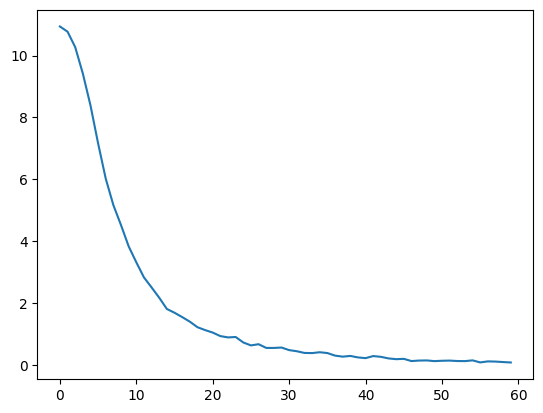

In [74]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [75]:
# mask = torch.Tensor(np.load(test_comp_df["mask"][0], allow_pickle=True)).view(1,1,128,128)
# mask = torch.Tensor(np.load(test_comp_df["mask"][0], allow_pickle=True)).view(1,1,128,128)

In [76]:
# net.sim_model(mask.cuda()).shape

In [77]:
test_dataset = CustomImageDataset(comp_df=test_triplet_df)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=len(test_triplet_df))

In [78]:
anchor_0, pos_0, neg_0 = next(iter(test_loader))

In [79]:
anchor = net.sim_model(anchor_0.cuda())
pos = net.sim_model(pos_0.cuda())
neg = net.sim_model(neg_0.cuda())

In [80]:
net.loss_fn(anchor, pos, neg)

tensor(3.0502, device='cuda:0', grad_fn=<MeanBackward0>)

In [81]:
train_loader = DataLoader(dataset, shuffle=True, batch_size=len(train_triplet_df))
_, train_pos, train_neg = next(iter(train_loader))

In [82]:
def get_embeddings(model, masks):
    return model(masks)

In [83]:
from scipy.spatial.distance import cdist

In [84]:
def eculidian_distance(x, y):
    return (x - y).pow(2).sum().sqrt()/2.0
    # return (x - y).pow(2).sum()

In [85]:
train_pos_embeddings = get_embeddings(net.sim_model, train_pos.cuda()).cpu().detach()
train_neg_embeddings = get_embeddings(net.sim_model, train_neg.cuda()).cpu().detach()

In [86]:
distance_modes=["euclidean",
               'minkowski',
               'cityblock',
               'sqeuclidean',
               'correlation',
               'chebyshev',
               'canberra',
               'braycurtis',
               'dice']

In [87]:
def distance(x,y,mode="euclidean"):
    return cdist(x,y, mode).sum()/y.shape[0]
    # return cdist(x,y, 'euclidean').sum()/y.shape[0]
    # return cdist(x,y, 'minkowski').sum()/y.shape[0]
    # return cdist(x, y, 'cityblock').sum()/y.shape[0]
    # return cdist(x, y, 'sqeuclidean').sum()/y.shape[0]
    # return cdist(x, y, 'correlation').sum()/y.shape[0] # Give False with neg samples
    # return cdist(x, y, 'chebyshev').sum()/y.shape[0]
    # return cdist(x, y, 'canberra').sum()/y.shape[0] # Give False with neg samples
    # return cdist(x, y, 'braycurtis').sum()/y.shape[0] # Give False with neg samples
    # return cdist(x, y, 'dice').sum()/y.shape[0] # Failed evaluation distance
    
    # return cdist(x, y, 'mahalanobis', VI=None).sum()/y.shape[0] # Search on it
    # return cdist(x, y, 'hamming').sum()/y.shape[0] # always gives 1
    # return cdist(x, y, 'jaccard').sum()/y.shape[0] # always gives 1
    # return cdist(x, y, 'jensenshannon').sum()/y.shape[0] # always inf # For probability vectors.
    # return cdist(x, y, 'yule').sum()/y.shape[0] # only for boolean vectors
    # return cdist(x, y, 'matching').sum()/y.shape[0] #Same as Hamming


In [88]:
results = []
for mode in distance_modes:
    tp = fn = 0
    pos_paths=list(set(test_triplet_df["pos"]))
    for i in range(len(pos_paths)):
        mask = torch.Tensor(np.load(pos_paths[i], allow_pickle=True)).view(1,1,128,128)
        mask_emb = net.sim_model(mask.cuda()).cpu().detach()
        pos_distance = distance(mask_emb, train_pos_embeddings)
        neg_distance = distance(mask_emb, train_neg_embeddings)
        if pos_distance<neg_distance:
            tp+=1
        else:
            fn+=1
            
    tn = fp = 0
    neg_paths=list(set(test_triplet_df["neg"]))
    for i in range(len(neg_paths)):
        mask = torch.Tensor(np.load(neg_paths[i], allow_pickle=True)).view(1,1,128,128)
        mask_emb = net.sim_model(mask.cuda()).cpu().detach()
        pos_distance = distance(mask_emb, train_pos_embeddings)
        neg_distance = distance(mask_emb, train_neg_embeddings)
        if pos_distance>neg_distance:
            tn+=1
        else:
            fp+=1

    results.append({"mode":mode,
                    "tp":tp,
                    "fp":fp,
                    "tn":tn,
                    "fn":fn})

In [91]:
len(neg_paths)

71

In [89]:
from tabulate import tabulate
headers = ["mode", "tp", "fp", "tn", "fn"]
for result in results:
    print(tabulate(result.items(), headers = headers))

mode    tp
------  ---------
mode    euclidean
tp      68
fp      50
tn      21
fn      1
mode    tp
------  ---------
mode    minkowski
tp      68
fp      52
tn      19
fn      1
mode    tp
------  ---------
mode    cityblock
tp      68
fp      50
tn      21
fn      1
mode    tp
------  -----------
mode    sqeuclidean
tp      68
fp      50
tn      21
fn      1
mode    tp
------  -----------
mode    correlation
tp      68
fp      55
tn      16
fn      1
mode    tp
------  ---------
mode    chebyshev
tp      68
fp      52
tn      19
fn      1
mode    tp
------  --------
mode    canberra
tp      68
fp      49
tn      22
fn      1
mode    tp
------  ----------
mode    braycurtis
tp      68
fp      51
tn      20
fn      1
mode    tp
------  ----
mode    dice
tp      68
fp      50
tn      21
fn      1


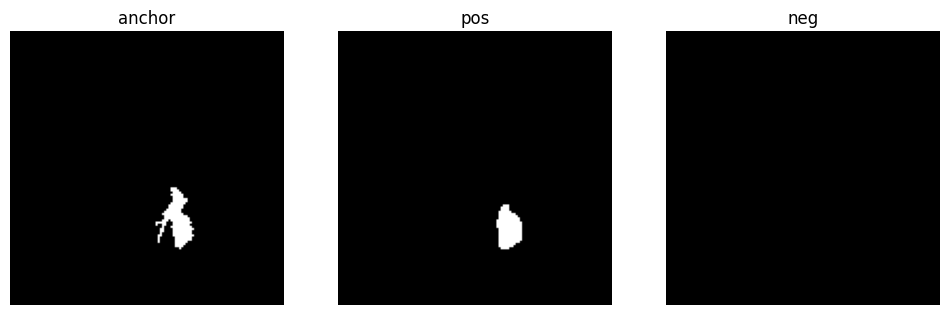

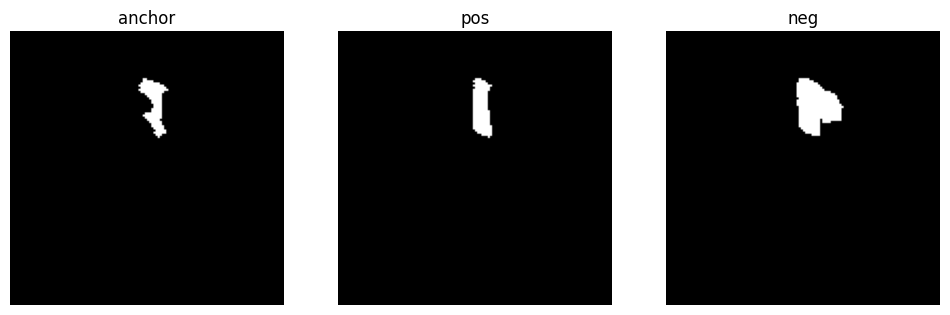

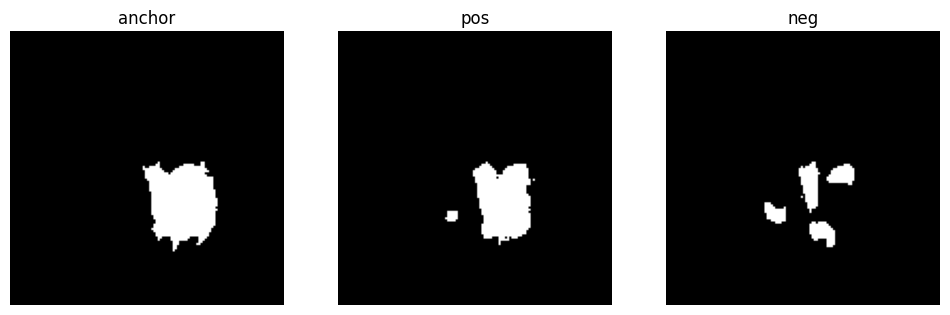

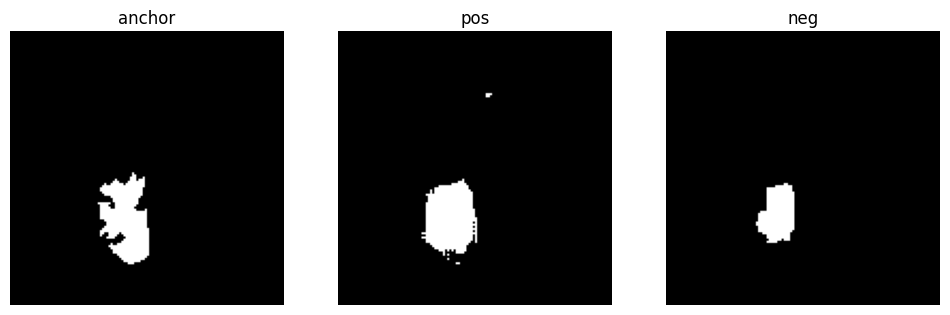

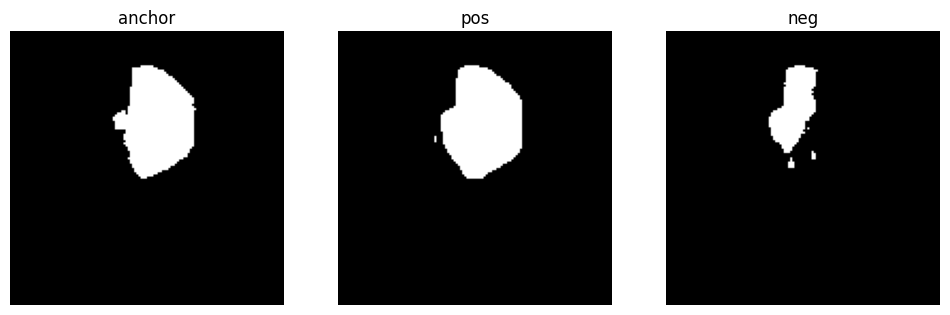

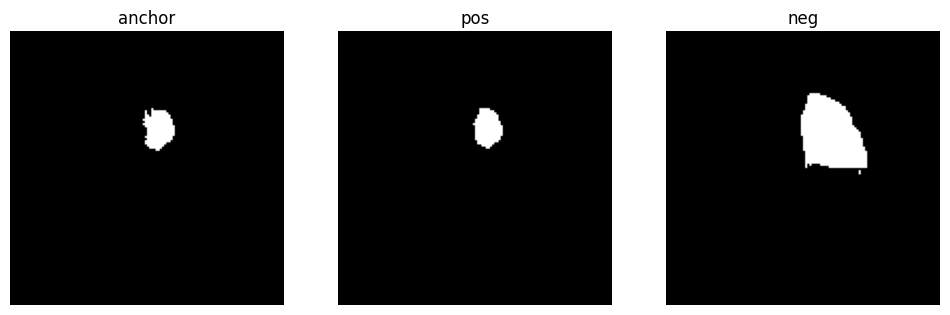

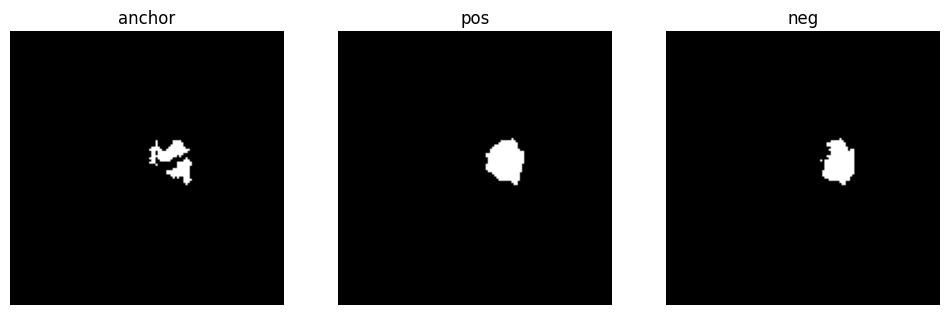

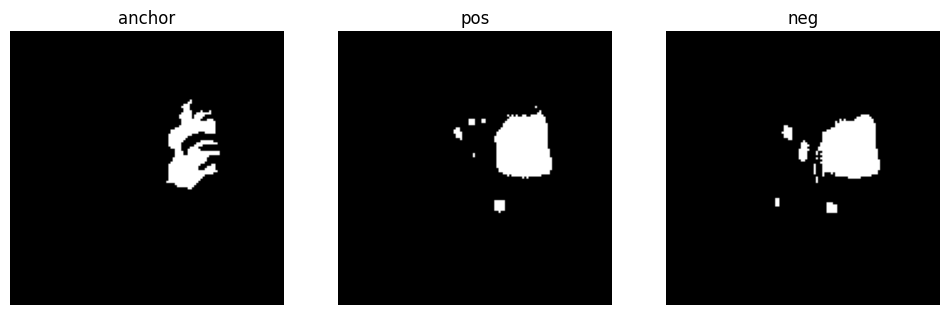

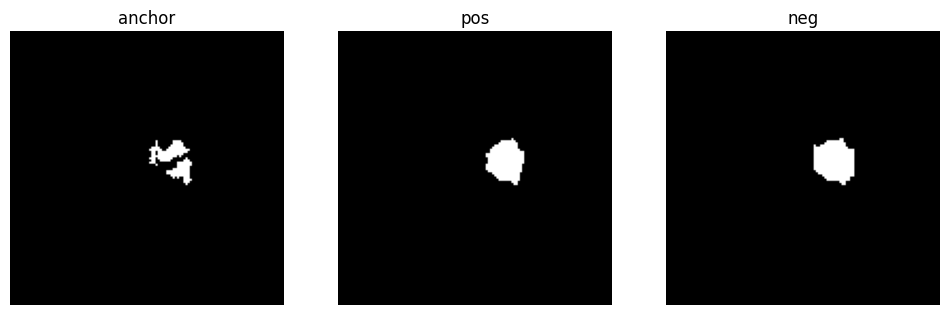

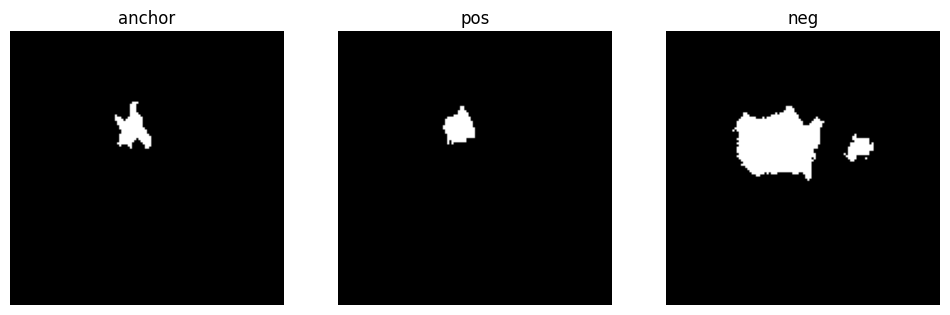

In [63]:
idx = 40
for i in range(idx, idx+10):
    sv.plot_images_grid(
        images=[anchor_0[i][0].cpu().detach().numpy(), pos_0[i][0].cpu().detach().numpy(), neg_0[i][0].cpu().detach().numpy()],
        grid_size=(1,3),
        titles=["anchor", "pos", "neg"]
    )

In [71]:
# print("Pred", "||", "GT")
# for x,y in zip(pred_sims, gt_sims):
#     print(x.cpu().squeeze(), "||", y)
    